In [13]:
from gensim import corpora, models, similarities
import gensim

In [14]:
import json 
import gzip 
#from StringIO import StringIO
import urllib.request
import requests, zipfile, io
import re

def parse(url): 
    if re.match("^http", url):
        r = requests.get(url)
        g = gzip.open(io.BytesIO(r.content))
    else:
        g = gzip.open(url, 'r') 
    for l in g:
        yield eval(l)

import json 
import gzip 
def parse(url): 
    g = gzip.open(url, 'r') 
    for l in g: 
        yield eval(l)

In [15]:
import gensim
import nltk
stoplist = nltk.corpus.stopwords.words('english')
lemma = nltk.stem.wordnet.WordNetLemmatizer()

def myReviews(review_files_urls, catFilter = None, asin = None, concatenate = False, max_count = None):
    preprocess_reviewText = []
    for url in review_files_urls:
        print("Processing url: " + url)
        review_item_iterator = iter(parse(url))
        it = 0
        conc_count = 0
        for review_item in review_item_iterator:
            it += 1
            if (max_count is not None) and (it > max_count):
                return
        #for it in range(1000000):
            if it%100000==0:
                print("it="+str(it))

            reviewText = review_item["reviewText"]
            label = review_item["asin"] + "_" + review_item["reviewerID"] 
            preprocess_reviewText_i = gensim.utils.simple_preprocess(reviewText)
            preprocess_reviewText_i = [lemma.lemmatize(word) for word in preprocess_reviewText_i if word not in stoplist]


            #yield gensim.models.doc2vec.LabeledSentence(words=preprocess_reviewText, tags=[label])
            if (catFilter == None or (catFilter in review_item["categories"])) and (asin == None or (asin == review_item["asin"])):
                if concatenate==False:
                    yield preprocess_reviewText_i
                else:
                    conc_count += 1
                    preprocess_reviewText.extend(preprocess_reviewText_i)
                    print("Concatenated count: "+str(conc_count))
    if concatenate == True:
        print("Return the final text with length: "+str(len(preprocess_reviewText)))
        print(preprocess_reviewText)
        yield preprocess_reviewText

#base_url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/"
base_url = "/media/mister/ntfs/Rainer/y2buy/download/amazon_reviews_96_14/"

from bs4 import BeautifulSoup
import urllib.request


html = urllib.request.urlopen("http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/")
soup = BeautifulSoup(html, 'html.parser')
#print(soup.prettify())
all_html_links = soup.find_all('a')
review_file_names = [links["href"] for links in all_html_links if re.match("^review.*[^_5|_10].json.gz$", links["href"])]

In [16]:
from os import listdir
from os.path import isfile, join
import re
#base_url = "/media/mister/ntfs/Rainer/y2buy/download/amazon_reviews_96_14/"
base_url = "/media/mister/Extension/dev/download/word2vec/"
onlyfiles = [f for f in listdir(base_url) if isfile(join(base_url, f))]
#review_file_names = [file for file in onlyfiles if re.match("^review.*[^_5|_10].json.gz$", file)]
review_file_names = ["reviews_Cell_Phones_and_Accessories_w_Cat.json.gz"]

for links in all_html_links:
    if re.match("^review.*[^_5|_10].json.gz$", links["href"]):
        print(links["href"])

In [17]:


review_file_names= ["reviews_Books_10.json.gz" if file_name =="reviews_Books.json.gz" else file_name for file_name in review_file_names]
print(review_file_names)
review_file_urls = [base_url + review_file_name for review_file_name in review_file_names]
#print(review_file_urls)

['reviews_Cell_Phones_and_Accessories_w_Cat.json.gz']


In [18]:
  
import os
#dictionaryFileName = '../../download/word2vec/reviews_all.dict'
dictionaryFileName = '../../download/word2vec/reviews_cell_phones.dict'
if os.path.isfile(dictionaryFileName)==False:
    #dictionary = corpora.Dictionary(myReviews("Cell Phones"))
    dictionary = corpora.Dictionary()
    for review_file_url in review_file_urls:
        dictionary.add_documents(myReviews([review_file_url],max_count = 1000000,catFilter="Cell Phones"))
        from six import iteritems
        once_ids = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq == 1]
        dictionary.filter_tokens(once_ids)  # remove stop words and words that appear only once
        dictionary.compactify()  # remove gaps in id sequence after words that were removed
        print(dictionary)
    dictionary.save(dictionaryFileName)  # store the dictionary, for future reference
else:
    dictionary = corpora.Dictionary.load(dictionaryFileName)



Processing url: /media/mister/Extension/dev/download/word2vec/reviews_Cell_Phones_and_Accessories_w_Cat.json.gz
it=100000
it=200000
it=300000
it=400000
it=500000
it=600000
it=700000
it=800000
it=900000
it=1000000
Dictionary(25993 unique tokens: ['product', 'came', 'exactly', 'described', 'would']...)



    
import os
dictionaryFileName = '../../download/word2vec/reviews_all.dict'
if os.path.isfile(dictionaryFileName)==False:
    #dictionary = corpora.Dictionary(myReviews("Cell Phones"))
    dictionary = corpora.Dictionary(myReviews(review_file_urls))
    from six import iteritems
    once_ids = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq == 1]
    dictionary.filter_tokens(once_ids)  # remove stop words and words that appear only once
    dictionary.compactify()  # remove gaps in id sequence after words that were removed
    dictionary.save(dictionaryFileName)  # store the dictionary, for future reference
else:
    dictionary = corpora.Dictionary.load(dictionaryFileName)

print(dictionary)

In [19]:
def myCorpus(review_file_urls, catFilter = None, asin = None, concatenate = False, max_count = None):
    for review in myReviews(review_file_urls,catFilter,asin,concatenate,max_count):
    # assume there's one document per line, tokens separated by whitespace
        yield dictionary.doc2bow(review)

In [21]:
import os
tfidfFileName ='../../download/word2vec/reviews_cell_phones.tfidf'

if os.path.isfile(tfidfFileName)==False:
    #tfidf = models.TfidfModel(myCorpus(review_file_urls,max_count = 1000000))
    tfidf = models.TfidfModel(myCorpus(review_file_urls,catFilter="Cell Phones"))
    tfidf.save(tfidfFileName)
else:
    tfidf = models.TfidfModel.load(tfidfFileName)
print(tfidf)

Processing url: /media/mister/Extension/dev/download/word2vec/reviews_Cell_Phones_and_Accessories_w_Cat.json.gz
it=100000
it=200000
it=300000
it=400000
it=500000
it=600000
it=700000
it=800000
it=900000
it=1000000
it=1100000
it=1200000
it=1300000
it=1400000
it=1500000
it=1600000
it=1700000
it=1800000
it=1900000
it=2000000
it=2100000
it=2200000
it=2300000
it=2400000
it=2500000
it=2600000
it=2700000
it=2800000
it=2900000
it=3000000
it=3100000
it=3200000
it=3300000
TfidfModel(num_docs=159702, num_nnz=5943554)


In [22]:
import pickle

#tfidf_document_FileName ='../../download/word2vec/reviews_cell_phones_review.tfidf'
tfidf_document_FileName ='../../download/word2vec/reviews_iPhone5s_of_cell_phones_dict.corpus'
if os.path.isfile(tfidf_document_FileName)==False:
    document = next(myCorpus(review_file_urls = ['../../download/word2vec/reviews_Cell_Phones_and_Accessories_w_Cat.json.gz'], asin="B00F3J4B5S",catFilter="Cell Phones",concatenate=True))
    document_tfidf = tfidf[document]  
    pickle.dump(document, open(tfidf_document_FileName, 'wb'))
else:
    document = pickle.load( open( tfidf_document_FileName, "rb" ) )
    document_tfidf = tfidf[document]  
    
document_dict = dict((tokenid, count) for tokenid, count in document)
    
    


Processing url: ../../download/word2vec/reviews_Cell_Phones_and_Accessories_w_Cat.json.gz
it=100000
it=200000
it=300000
it=400000
it=500000
it=600000
it=700000
it=800000
it=900000
it=1000000
it=1100000
it=1200000
it=1300000
it=1400000
it=1500000
it=1600000
it=1700000
it=1800000
it=1900000
it=2000000
it=2100000
it=2200000
it=2300000
it=2400000
it=2500000
it=2600000
it=2700000
it=2800000
it=2900000
it=3000000
Concatenated count: 1
Concatenated count: 2
Concatenated count: 3
Concatenated count: 4
Concatenated count: 5
Concatenated count: 6
Concatenated count: 7
Concatenated count: 8
Concatenated count: 9
Concatenated count: 10
Concatenated count: 11
Concatenated count: 12
Concatenated count: 13
Concatenated count: 14
Concatenated count: 15
Concatenated count: 16
Concatenated count: 17
Concatenated count: 18
Concatenated count: 19
Concatenated count: 20
Concatenated count: 21
Concatenated count: 22
Concatenated count: 23
Concatenated count: 24
Concatenated count: 25
Concatenated count: 26


it=3100000
it=3200000
it=3300000
Return the final text with length: 12547
['going', 'use', 'apple', 'downloads', 'apps', 'use', 'audible', 'anything', 'else', 'bought', 'apple', 'phone', 'might', 'okay', 'however', 'apple', 'discriminates', 'product', 'bought', 'itunes', 'store', 'example', 'audio', 'book', 'bought', 'itunes', 'backed', 'itunes', 'library', 'one', 'pc', 'audible', 'book', 'downloaded', 'audible', 'app', 'far', 'found', 'way', 'back', 'itunes', 'audiobook', 'library', 'pc', 'addition', 'apple', 'seems', 'use', 'cellular', 'data', 'daily', 'basis', 'upload', 'half', 'megabyte', 'think', 'word', 'term', 'paper', 'worth', 'data', 'daily', 'even', 'turned', 'push', 'notification', 'siri', 'location', 'service', 'everything', 'else', 'thing', 'stop', 'upload', 'turning', 'wifi', 'cellular', 'data', 'much', 'smartphone', 'matter', 'garbage', 'collection', 'one', 'load', 'something', 'onto', 'phone', 'later', 'deletes', 'storage', 'seem', 'become', 'available', 'one', 'back', 

In [23]:
import gensim
model = gensim.models.Word2Vec.load('../../download/word2vec/myamazonmodel.word2vec')
#model = gensim.models.KeyedVectors.load_word2vec_format('../../download/word2vec/GoogleNews-vectors-negative300.bin', binary=True, limit=400000) 

In [24]:
import numpy as np
import pandas as pd
tbl =[[dictionary.get(tokenid), document_dict[tokenid], tfidf_value ,model.wv[dictionary.get(tokenid)] ] for (tokenid,tfidf_value) in document_tfidf if tfidf_value > 0.05 and dictionary.get(tokenid) in model.wv]

df = pd.DataFrame(data=tbl,
                  columns=["token","term_freq","tfidf", "word_vector"]
                  )
df = df.sort_values('tfidf', ascending=False)
df.set_index("token")
print(df)

          token  term_freq     tfidf  \
55       iphone        335  0.493194   
48        apple        174  0.376173   
19          new        111  0.119122   
53     unlocked         68  0.103725   
50  fingerprint         28  0.096419   
5           get        108  0.094567   
54           io         32  0.088370   
45           id         29  0.087644   
29        touch         56  0.086885   
9           use        107  0.086547   
27         case         51  0.085936   
16       better         66  0.084611   
0       product         63  0.084481   
39       finger         36  0.084054   
6          work        110  0.083350   
49        print         26  0.083030   
20          one        104  0.080149   
23         time         85  0.078642   
10         make         60  0.075456   
59      scanner         18  0.073038   
56       sensor         23  0.070621   
57         gold         18  0.068135   
1         would         73  0.067646   
30       screen         72  0.067561   


In [25]:
import nltk
from nltk.cluster.kmeans import KMeansClusterer
nc = 5
data = df.loc[:,"word_vector"]
#print(data)
kclusterer = KMeansClusterer(nc, distance=nltk.cluster.util.cosine_distance, avoid_empty_clusters=True) #repeats=30,
assigned_clusters = kclusterer.cluster(data, assign_clusters=True)
#print(assigned_clusters)
means = np.asarray( kclusterer.means())


In [26]:
df["cluster_kmeans"] = pd.Series(assigned_clusters, index=df.index)

In [27]:
data = np.array([row for row in data])
print(data)


[[-2.20163846 -0.34640202 -1.60772383 ..., -1.08009326  1.36995173
   1.48971546]
 [-0.45952713  1.19458425  0.44155249 ..., -0.46884674  1.99435806
   0.07208828]
 [-2.00251722 -0.47759703 -0.23757146 ..., -2.02588582 -0.83637464
  -0.9285928 ]
 ..., 
 [-0.61203265 -0.06866466 -2.34162855 ..., -0.33635956 -0.91583115
  -1.83430123]
 [ 0.95052612 -0.17758705 -0.3356927  ..., -1.18796539 -0.40357459
   0.20218305]
 [ 3.03685546 -2.23334289  1.96035326 ..., -0.30659038 -0.82897037
  -4.23737383]]


In [28]:
#print(data.shape)
#print(data[0].shape)
#print(type(data[0]))
#print(data[0])

In [29]:
from sklearn.cluster import DBSCAN
from sklearn import metrics


#db = DBSCAN(eps=0.03, min_samples=10).fit(data)
db = DBSCAN(min_samples=2, metric='cosine', algorithm='brute').fit(data) #metric="cosine"
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
print(len(labels))
print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)

#print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))

62
[ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1  2 -1 -1 -1 -1 -1 -1  0
 -1 -1 -1 -1  0  2 -1 -1 -1 -1 -1  3 -1 -1  2 -1 -1 -1 -1  3  3  3 -1  4 -1
 -1  0 -1  1 -1 -1  3 -1 -1  4 -1 -1]
5


In [30]:
df["cluster_dbscan"] = pd.Series(labels, index=df.index)

print(df.shape)
print(df)

(62, 6)
          token  term_freq     tfidf  \
55       iphone        335  0.493194   
48        apple        174  0.376173   
19          new        111  0.119122   
53     unlocked         68  0.103725   
50  fingerprint         28  0.096419   
5           get        108  0.094567   
54           io         32  0.088370   
45           id         29  0.087644   
29        touch         56  0.086885   
9           use        107  0.086547   
27         case         51  0.085936   
16       better         66  0.084611   
0       product         63  0.084481   
39       finger         36  0.084054   
6          work        110  0.083350   
49        print         26  0.083030   
20          one        104  0.080149   
23         time         85  0.078642   
10         make         60  0.075456   
59      scanner         18  0.073038   
56       sensor         23  0.070621   
57         gold         18  0.068135   
1         would         73  0.067646   
30       screen         72  0.06

In [31]:
df["centroid"] = pd.Series( means[assigned_clusters].tolist(), index=df.index)

print(df.shape)
print(df)


(62, 7)
          token  term_freq     tfidf  \
55       iphone        335  0.493194   
48        apple        174  0.376173   
19          new        111  0.119122   
53     unlocked         68  0.103725   
50  fingerprint         28  0.096419   
5           get        108  0.094567   
54           io         32  0.088370   
45           id         29  0.087644   
29        touch         56  0.086885   
9           use        107  0.086547   
27         case         51  0.085936   
16       better         66  0.084611   
0       product         63  0.084481   
39       finger         36  0.084054   
6          work        110  0.083350   
49        print         26  0.083030   
20          one        104  0.080149   
23         time         85  0.078642   
10         make         60  0.075456   
59      scanner         18  0.073038   
56       sensor         23  0.070621   
57         gold         18  0.068135   
1         would         73  0.067646   
30       screen         72  0.06

In [32]:
df["centroid_distance"] = df.apply(lambda row:nltk.cluster.util.cosine_distance(row['word_vector'], row['centroid']), axis=1)

print(df.shape)
print(df)

(62, 8)
          token  term_freq     tfidf  \
55       iphone        335  0.493194   
48        apple        174  0.376173   
19          new        111  0.119122   
53     unlocked         68  0.103725   
50  fingerprint         28  0.096419   
5           get        108  0.094567   
54           io         32  0.088370   
45           id         29  0.087644   
29        touch         56  0.086885   
9           use        107  0.086547   
27         case         51  0.085936   
16       better         66  0.084611   
0       product         63  0.084481   
39       finger         36  0.084054   
6          work        110  0.083350   
49        print         26  0.083030   
20          one        104  0.080149   
23         time         85  0.078642   
10         make         60  0.075456   
59      scanner         18  0.073038   
56       sensor         23  0.070621   
57         gold         18  0.068135   
1         would         73  0.067646   
30       screen         72  0.06

In [33]:
# now hierarchical clustering
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
# needed imports
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

In [34]:
# some setting for this notebook to actually show the graphs inline, you probably won't need this
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [35]:
# generate the linkage matrix
Z = linkage(data, metric='cosine')
#Z = linkage(data, 'ward')

In [36]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(data))
c

0.24890412419689548

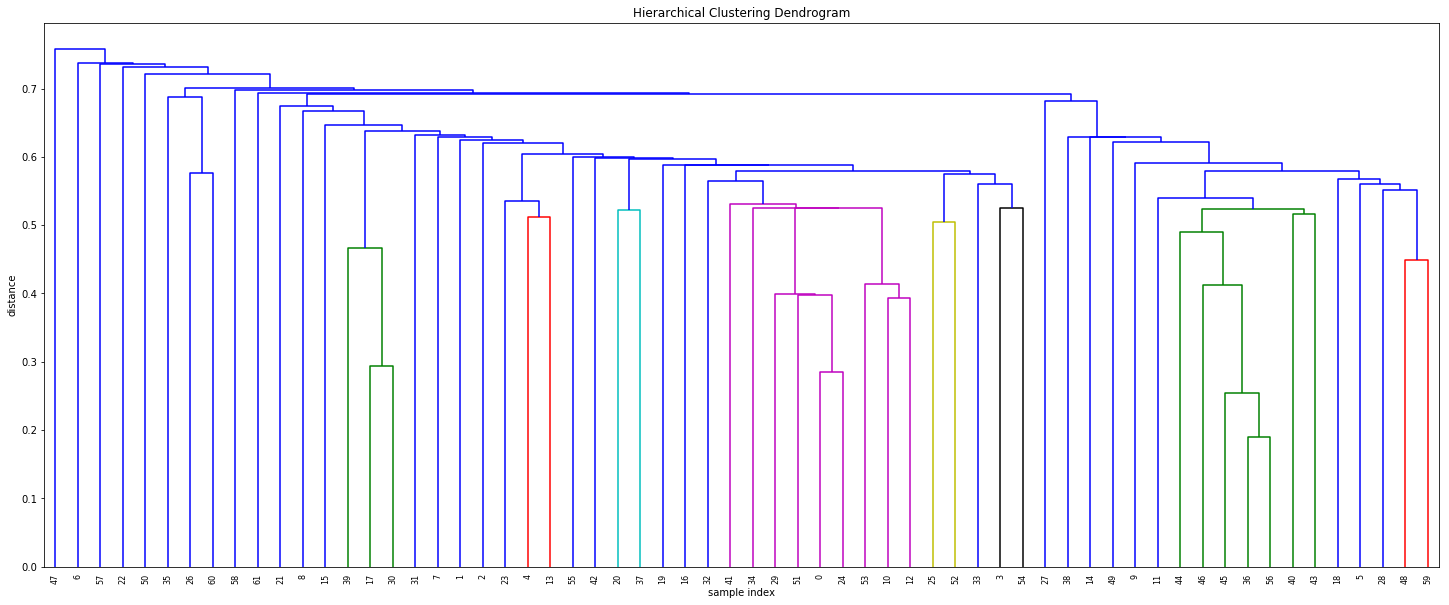

In [37]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

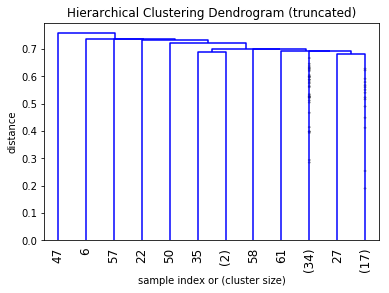

In [38]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [61]:
from scipy.cluster.hierarchy import fcluster

#k=12
#cluster_hierachical = fcluster(Z, k, criterion='maxclust')


#max_d = 0.4
#cluster_hierachical = fcluster(Z, max_d, criterion='distance')
#cluster_hierachical

cluster_hierachical = fcluster(Z, 0.8, depth=2)
cluster_hierachical


array([ 5, 16, 15, 10,  3, 23, 34, 17, 20, 24,  6, 22,  6,  3, 26, 19, 11,
        2, 23, 12,  4, 21, 32,  3,  5, 10,  1, 28, 23,  5,  2, 18,  9, 10,
        7,  1, 22,  4, 27,  2, 22,  8, 13, 22, 22, 22, 22, 35, 23, 25, 31,
        5, 10,  6, 10, 14, 22, 33, 30, 23,  1, 29], dtype=int32)

In [62]:
df["cluster_hierarchical"] = pd.Series(cluster_hierachical, index=df.index)
#print(df.shape)
#print(df)

In [63]:
writer = pd.ExcelWriter('clustered_smartphone_features_iPhone5s.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()